<a href="https://colab.research.google.com/github/IcaArinda/Customers-Segmentation/blob/main/K_MEANS_CUSTOMERS_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-MEANS UNTUK SEGMENTASI KONSUMEN MALL

Dataset : https://www.kaggle.com/datasets/kandij/mall-customers


In [1]:
#@title import library

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# clustering
from sklearn.cluster import KMeans

# processing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# dimentionaly reduction (for EDA)
from sklearn.decomposition import PCA

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Visualitation setting
plt.style.use('seaborn-v0_8')
sns.set_context("notebook", font_scale=1.1)

In [2]:
#@title Load data

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/datasets/Mall_Customers.csv'
df = pd.read_csv(path)

df.head()

Mounted at /content/drive


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
#@title Initial Data Check
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
#@title Encode Categorical Feature
df['Genre'] = (
    df['Genre']
    .str.strip()
    .str.capitalize()
    .map({'Male': 0, 'Female': 1})
    .astype('int64')
)

In [5]:

df.rename(columns={'Genre' : 'Gender'}, inplace=True) #rename genre as gender
df['Gender'].value_counts()
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Gender                  200 non-null    int64
 2   Age                     200 non-null    int64
 3   Annual Income (k$)      200 non-null    int64
 4   Spending Score (1-100)  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB


CLEANING DATASET

In [7]:
#@title cleaning dataset

df.isna().sum()
df.duplicated().sum()

np.int64(0)

In [9]:
x=df["Gender"].value_counts()
x

,count
Gender,
1,112
0,88


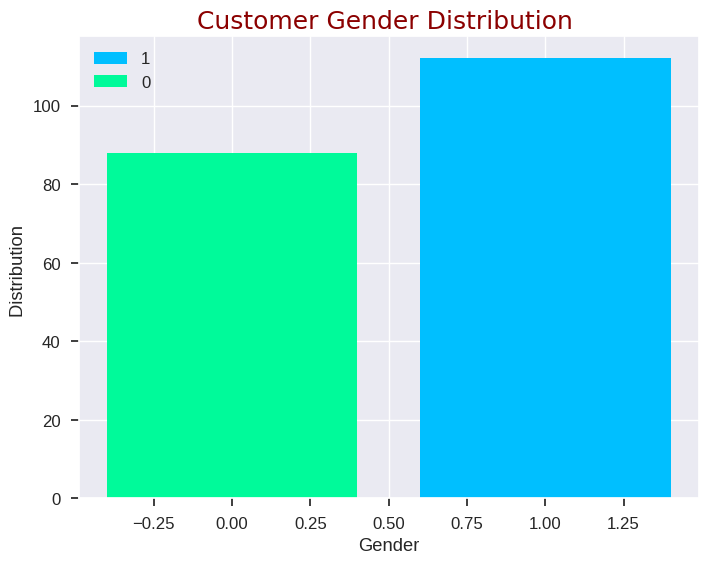

In [10]:
#@title data visualization

plt.figure(figsize=(8,6))
plt.title("Customer Gender Distribution ",fontdict={"fontname":"Comic Sans MS","fontsize":18},color="DarkGray")
plt.bar(x.index,x.values,label=x.index,color=["DeepSkyBlue","MediumSpringGreen"])
plt.legend(loc ="best")
plt.xlabel("Gender")
plt.ylabel("Distribution ")
plt.show()

In [16]:
#@title Feature Selection

df_ds = df.drop(columns=['CustomerID'])
df_ds.head()
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Gender                  200 non-null    int64
 1   Age                     200 non-null    int64
 2   Annual Income (k$)      200 non-null    int64
 3   Spending Score (1-100)  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


In [19]:
X = df_ds[['Annual Income (k$)', 'Spending Score (1-100)']]
X_age = df_ds[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
X_full = df_ds[['Gender','Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
x.describe()

,count
count,2.000000
mean,100.000000
std,16.970563
min,88.000000
25%,94.000000
50%,100.000000
75%,106.000000
max,112.000000


In [20]:
#@title Scaling

#import and fit
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(
    X_scaled,
    columns=X.columns
)

X_scaled.head()

,Annual Income (k$),Spending Score (1-100)
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


In [21]:
X_scaled.describe()

,Annual Income (k$),Spending Score (1-100)
count,2.000000e+02,2.000000e+02
mean,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00
min,-1.738999e+00,-1.910021e+00
25%,-7.275093e-01,-5.997931e-01
50%,3.587926e-02,-7.764312e-03
75%,6.656748e-01,8.851316e-01
max,2.917671e+00,1.894492e+00


In [22]:
#@title Modeling
wcss = []

for k in range(1, 11):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

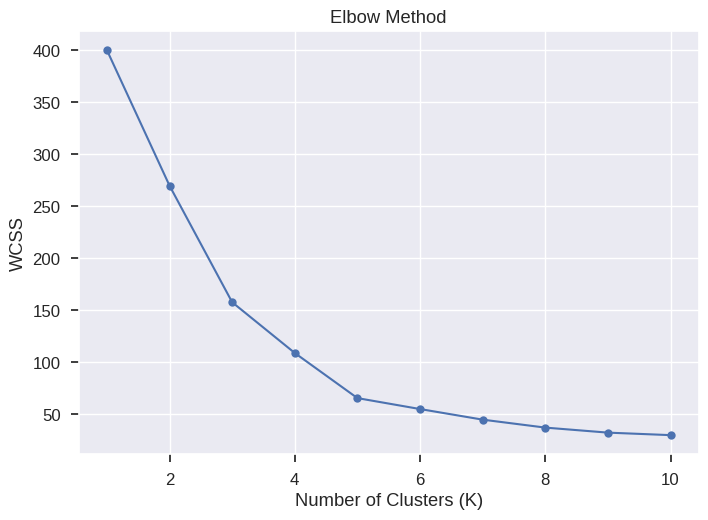

In [23]:
#show the plot
plt.figure()
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

Based on the Elbow Method, the plot shows a clear bend at K = 5, where the decrease in WCSS starts to level off. This indicates that adding more clusters beyond 5 does not provide a significant improvement in clustering performance.

In [24]:
#@title Training Model

#train K-Means (K=5)
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=5,
    random_state=42,
    n_init=10
)

clusters = kmeans.fit_predict(X_scaled)

In [25]:
df['Cluster'] = clusters
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,0,19,15,39,4
1,2,0,21,15,81,2
2,3,1,20,16,6,4
3,4,1,23,16,77,2
4,5,1,31,17,40,4


In [26]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.20091257, -0.02645617],
       [ 0.99158305,  1.23950275],
       [-1.32954532,  1.13217788],
       [ 1.05500302, -1.28443907],
       [-1.30751869, -1.13696536]])

In [27]:
centroids_original = scaler.inverse_transform(centroids)

centroids_original = pd.DataFrame(
    centroids_original,
    columns=X.columns
)

centroids_original

,Annual Income (k$),Spending Score (1-100)
0,55.296296,49.518519
1,86.538462,82.128205
2,25.727273,79.363636
3,88.200000,17.114286
4,26.304348,20.913043


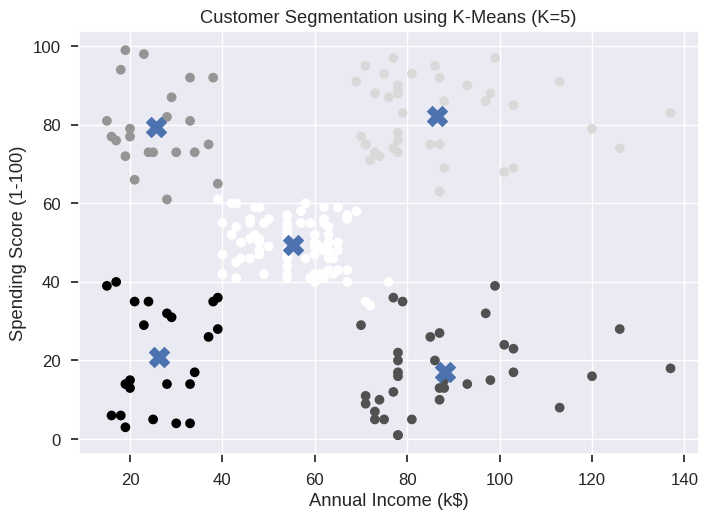

In [28]:
plt.figure()
plt.scatter(
    df['Annual Income (k$)'],
    df['Spending Score (1-100)'],
    c=df['Cluster']
)

plt.scatter(
    centroids_original['Annual Income (k$)'],
    centroids_original['Spending Score (1-100)'],
    marker='X',
    s=200
)

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segmentation using K-Means (K=5)')
plt.show()

Using K-Means with K = 5, customers were successfully segmented based on their annual income and spending behavior, allowing for clearer identification of distinct customer groups

The K-Means (K=5) clustering divides customers into five distinct segments based on annual income and spending score: low-income low-spending customers who are price-sensitive, low-income high-spending customers who tend to be impulsive, medium-income medium-spending customers who are stable and consistent, high-income low-spending customers who are selective and cautious, and high-income high-spending customers who are the most valuable. This segmentation helps businesses tailor marketing strategies, such as discounts for budget-conscious groups, loyalty programs for impulsive spenders, engagement strategies for average customers, value-driven offers for cautious high-income customers, and exclusive VIP treatments for top spenders.

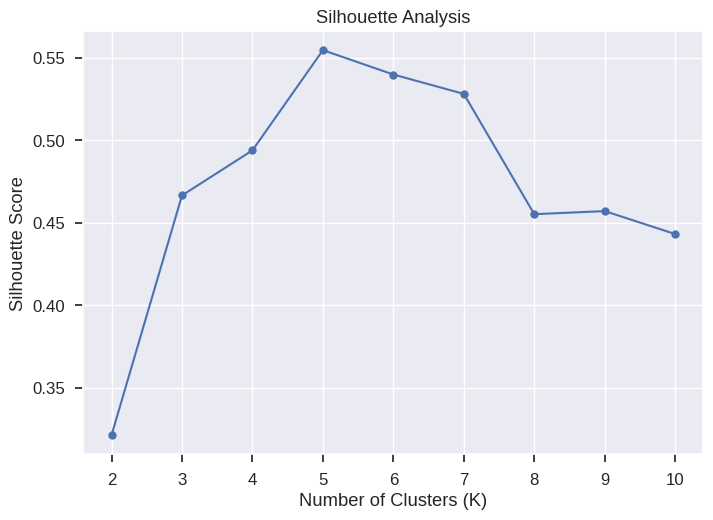

In [29]:
#@title Evaluation
sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure()
plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()